<a href="https://colab.research.google.com/github/naymark/CNN-primase/blob/main/CNN_primase_multi_conv_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building, interpreting and evaluating a CNN trained to find important sequence regions related to potential transcription factor binding sites on DNA sequences.**

**In this notebook we build a CNN and interpret it in order to find transcription factor binding sites on the DNA sequences.**

In [ ]:
# Install and import dependencies

In [ ]:
pip install shap # Used to extract the expected gradients

In [ ]:
pip install adabelief-tf==0.2.1 # Optimizer that was found to be most effective

In [ ]:
pip install modisco # Tool to visualize the nucleotides making up the binding sites

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import shap
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model, load_model, Sequential
from google.colab import drive
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorboard.plugins.hparams import api as hp
import tensorflow_probability as tfp
from scipy import stats
import datetime
from adabelief_tf import AdaBeliefOptimizer
import os
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.utils import np_utils
import gc
import modisco
import modisco.visualization
from modisco.visualization import viz_sequence
import plotly.express as px
from tensorflow.keras import backend as K

In [ ]:
%load_ext tensorboard
# Used to evaluate the model during training and hyperparameter tuning

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# **How the data was processed and models built:**

Here we define the functions to process the data and build the network.

The neural networks created and used in this notebook were trained to find combinations of 3-mers, 4-mers, 5-mers and 6-mers.

The first model takes an input of DNA sequences represented by 36 features of individual nucelotides (the actual sequences are 60 bp, but we removed the last 24, which are the same and seem to be the linker segment) and runs over them with 4 consecutive convolutional layers.
- The first convolutional layer, with a kernel size of 3, is meant to find 3-mers (as the receptive field of such a kernel is 3).

- *Note that we used the GELU (Gaussian Error Linear Unit) activation function after using ReLU and analyzing one of the network's hidden layers and finding that the matrix had many zeros, an indication of dead ReLUs, and that certain neurons were no longer updating during training.
(https://mlfromscratch.com/activation-functions-explained/#gelu)
While some point out that this can make training a neural network more efficient, here we found that use of GELU reulted in significantly higher predictive accuracy of the model.*

- The second, third and fourth convolutional layers, each with a kernel size of 2, are meant to find 4-, 5- and 6-mers, respectively (as the receptive field of each such consecutive layer expands by 1.

- See https://distill.pub/2019/computing-receptive-fields/#computing-receptive-field-region for a thorough description of the receptive fields of consecutive layers of a neural network.
- Using these models, expected gradients were calculated, and these values were plotted, for a few sequences with a high fluorescence label, using tf-modisco visualizations (expected gradients and tf-modisco are further described and referenced below).

In [ ]:
# Functions to import and preprocess the data, and to build and train the model
def importDataSet():
    data = pd.read_csv(r'/content/gdrive/MyDrive/Mtb.csv')
    data.drop(columns=['ID','Sequence'], inplace=True)
    data.drop(columns=data.columns[37:-1], inplace=True)
    return data

def splitDataToLabels_Features(data):
    features = data.drop(columns=['name2','F488 Median']).to_numpy()
    labels = data['F488 Median'].to_numpy()#.values
    labels=labels.reshape(len(labels),1)
    return features, labels

def encoding_features(data, sequence_type, k_mers=3):
    num_cols = data[data.columns[1:-1]].shape[1]
    encoded_data = pd.get_dummies(data, columns = data.columns[1:-1])
    if sequence_type == 'all':
      encoded_data = encoded_data
    elif sequence_type == 'de_bruijn':
      encoded_data = encoded_data[encoded_data['name2'].str.startswith('DE', na=False)]
    elif sequence_type == 'k-mers':
      encoded_data = encoded_data[encoded_data['name2'].str.startswith('4', na=False) |
                  encoded_data['name2'].str.startswith('5', na=False) |
                  encoded_data['name2'].str.startswith('6', na=False)]
    num_rows = encoded_data.shape[0]
    return data, encoded_data, num_cols, num_rows

def reshape_features(features, num_cols, num_rows):
    features = features.reshape(num_rows,num_cols,-1)
    return features

def scale_labels(train_labels, test_labels):
    minmax_sc = MinMaxScaler()
    minmax_sc.fit(train_labels)
    train_labels=minmax_sc.transform(train_labels)
    test_labels=minmax_sc.transform(test_labels)
    return train_labels, test_labels

def preprocess_data(sequence_type='all', scale_label=True):
    data = importDataSet()
    data, encoded_data, num_cols, num_rows = encoding_features(data,sequence_type)
    features,labels = splitDataToLabels_Features(encoded_data)
    features = reshape_features(features, num_cols, num_rows)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.1, random_state = 1)
    if scale_label:
      y_train, y_test = scale_labels(y_train, y_test)
    return X_train, X_test, y_train, y_test, data, features

def tf_pearson(y_true, y_pred): # Pearson used as the model's accuracy metric
    return tfp.stats.correlation(y_true, y_pred)

def build_cnn(final_units=1, final_activation=None):
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv1D(filters=512, kernel_size=1, strides=1, input_shape=[36,4], name='conv1d_layer'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Activation('gelu'))
    cnn.add(tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, name='second_conv1d_layer'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Activation('gelu'))
    cnn.add(tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, name='third_conv1d_layer'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Activation('gelu'))
    cnn.add(tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, name='fourth_conv1d_layer'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Activation('gelu'))
    cnn.add(tf.keras.layers.GlobalMaxPooling1D(name='maxpool_layer'))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(units=64, activation=None, name='dense_layer'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Activation('gelu'))
    cnn.add(tf.keras.layers.Dropout(0.2, name='dropout_layer'))
    cnn.add(tf.keras.layers.Dense(units=final_units, activation=final_activation, name='output_layer'))
    return cnn

# Create a function where the model is trained using automatic hyperparameter tuning
def train_test_hparams(hparams, final_units=1, final_activation=None):
    cnn = tf.keras.models.Sequential(build_cnn().layers[:-1])
    cnn.add(tf.keras.layers.Dense(units=hparams[HP_NUM_UNITS], activation='gelu', name='second_dense_layer'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Activation('gelu'))
    cnn.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
    cnn.add(tf.keras.layers.Dense(units=final_units, activation=final_activation, name='output_layer'))
    cnn.compile(optimizer = hparams[HP_OPTIMIZER], loss = 'mean_squared_error', metrics = ['accuracy'])
    
    # Use callbacks to enable TensorBoard logging of the parameters during training
    cnn.fit(x=X_train, 
              y=y_train, 
              epochs=3,
              batch_size=32,
              callbacks=[tensorboard_callback],
              validation_split=0.1)
    _, accuracy = cnn.evaluate(X_test, y_test)
    return accuracy, cnn 

def run_hparam_tuner(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy, cnn = train_test_hparams(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

# Here we create the model (that takes sequences processed as individual nucleotides) and load the data, using the functions defined above.

Note:
- We use AdaBelief as an optimizer, which is claimed by the authors of the paper (https://arxiv.org/abs/2010.07468) to train as fast as Adam and generalize as well as SGD.
- We also use Pearson correlation as a metric
- Finally, note that the debruin set alone did not train any model well; the k-mer dataset worked very well with most models but failed in some; and the entire dataset was the most resilient across models

In [ ]:
# Create initial CNN and choose DNA sequence type ['all', 'k-mers', 'de_bruijn']
OUTPUT = 1 # This is the number of neurons in the last layer, 1 fits a regression problem;
          # \ if we're dealing with classifications we need num_neurons=num_categories
ACTIV = None
cnn = build_cnn(final_units=OUTPUT, final_activation=ACTIV)

# Compile the CNN
OPTIMIZER = AdaBeliefOptimizer(learning_rate=1e-2, epsilon=1e-14, rectify=False, print_change_log = False)
LOSS = tf.keras.losses.MeanSquaredError()    
METRICS = tf_pearson
cnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS])

SEQUENCE_TYPE = 'all'
X_train, X_test, y_train, y_test, data, features = preprocess_data(sequence_type=SEQUENCE_TYPE, scale_label=True)

We create some callbacks to enable logging and early stopping while training the model.

In [ ]:
log_dir = 'logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stops = EarlyStopping(patience=15, monitor='val_tf_pearson', mode='max', restore_best_weights=True)
filepath = '/content/gdrive/MyDrive/cnn_model'
ckpt_callback = ModelCheckpoint(filepath=filepath,
                              monitor='val_tf_pearson', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

The following code is to aid in hyperparameter tuning, **prior** to training, evaluating and interpreting the best model.

In [ ]:
# Train the model using hyperparameter tuning logged to TensorBoard
"""
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 16]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop'])) # In the end we chose Adabelief (see above),
#\ because after hyperparameter tuning we got the best pearson correlation
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )
  
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run_hparam_tuner('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1 
"""

After running the hyperparameter tuning code above, the metrics of the models using each combination of hyperparameters can be compared using Tensorboard:

In [ ]:
#!kill XXXX

In [ ]:
# Compare hyperparameter metrics
#%tensorboard --logdir logs/hparam_tuning

We train the CNN using the best hyperparameters.

In [ ]:
# Train the CNN with the chosen hyperparameters and save best model
cnn.fit(x=X_train,
              y=y_train,
              epochs=150,
              batch_size=32,
              callbacks=[tensorboard_callback, early_stops, ckpt_callback],
              validation_split=0.2)

# Save best model
filename = '/content/gdrive/MyDrive/cnn_model/cnn_model_' + SEQUENCE_TYPE + str(OUTPUT) + ('' if ACTIV == None else ACTIV)\
  + LOSS.name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cnn.save(filename)

In [ ]:
# Fine-tune using smaller learning rate
dependencies = {'tf_pearson': tf_pearson}
OPTIMIZER = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False, print_change_log = False)
cnn = load_model(filename, compile=False, custom_objects=dependencies)
cnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS])
cnn.fit(x=X_train, 
          y=y_train, 
          epochs=150,
          batch_size=32,
          callbacks=[tensorboard_callback, early_stops, ckpt_callback],
          validation_split=0.2)

# Re-save best model
cnn.save(filename)

In [ ]:
# Further fine-tune using smaller learning rate
dependencies = {'tf_pearson': tf_pearson}
OPTIMIZER = AdaBeliefOptimizer(learning_rate=1e-4, epsilon=1e-14, rectify=False, print_change_log = False)
cnn = load_model(filename, compile=False, custom_objects=dependencies)
cnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS])
cnn.fit(x=X_train, 
          y=y_train, 
          epochs=150,
          batch_size=32,
          callbacks=[tensorboard_callback, early_stops, ckpt_callback],
          validation_split=0.2)

# Re-save best model
cnn.save(filename)

In [ ]:
#!kill XXXX

The updated accuracy and loss of the model throughout training can be seen using Tensorboard.

In [ ]:
# Show model with histograms of the trainable parameters
%tensorboard --logdir logs/fit/

Here we load some of our pre-trained models for evaluation and interpretation.

In [ ]:
dependencies = {'tf_pearson': tf_pearson}
OPTIMIZER = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False, print_change_log = False)
# Three-mer model
#cnn = load_model('/content/gdrive/MyDrive/cnn_model/cnn_model_all1mean_squared_error20210506-194646',\
#                 compile=False, custom_objects=dependencies)
# Four-mer model
#cnn = load_model('/content/gdrive/MyDrive/cnn_model/cnn_model_all1mean_squared_error20210420-065811',\
#                 compile=False, custom_objects=dependencies)
# Model with 3-, 4-, 5- and 6-mer conv layers 
cnn = load_model('/content/gdrive/MyDrive/cnn_model/cnn_model_all1mean_squared_error20210418-074354',\
                 compile=False, custom_objects=dependencies)
cnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS])

Here we evaluate the CNN. The current model gives a Pearson correlation of .92 on the test set. We can now proceed to interpret what the model has learned in terms of important k-mers which may reflect transcription factor binding sites in a given sequence.

In [ ]:
# Evaluate model on the test set
cnn.evaluate(X_test, y_test)

185/185 [==============================] - 2s 5ms/step - loss: 0.0081 - tf_pearson: 0.9271


[0.00854681059718132, 0.92496258020401]

Here we extract the expected gradients of the model. Expected gradients are a combination of the integrated gradients and shapley values.

The point of this is to use the values as importance scores which we then plotted in one of the following ways:

1.   As shown in the DeepSELEX paper (https://pubmed.ncbi.nlm.nih.gov/33381817/, the importance scores can be plotted using the tf-modisco library  (https://github.com/kundajelab/tfmodisco).

2.   Alternatively, the expected gradients can be attributed to each feature of the input (whether per nucleotide or k-mer, depending on the model used), and then plotted, for example in a bar graph.



In [ ]:
#Extract the expected gradients using GradientExplainer, in order to interpret the important features found by the model
#(https://shap-lrjball.readthedocs.io/en/latest/index.html)
explainer = shap.GradientExplainer(cnn, X_train)

In [ ]:
predictions = cnn.predict(X_test) # Generate predictions and sort test set based on predicted label (descending)
pred_hi_idx = np.argsort(predictions, axis=0)[::-1]
X_test_sorted = X_test[pred_hi_idx[:,0]]
X_test_top_100 = X_test_sorted[:100]

In [ ]:
shap_values = explainer.shap_values(X_test_top_100) # Get expected gradient values (use X_test_top_100 for top 100 test sequences)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



In [ ]:
minmax_sc = MinMaxScaler()

In [ ]:
shap_values_scaled = np.reshape(minmax_sc.fit_transform(np.reshape(shap_values[0], (shap_values[0].shape[0],-1))),(shap_values[0].shape[0],shap_values[0].shape[1],-1))

In [ ]:
# This is when choosing not to scale the expected gradients
shap_values_scaled = shap_values[0]

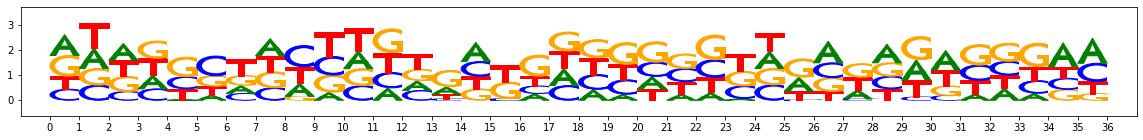

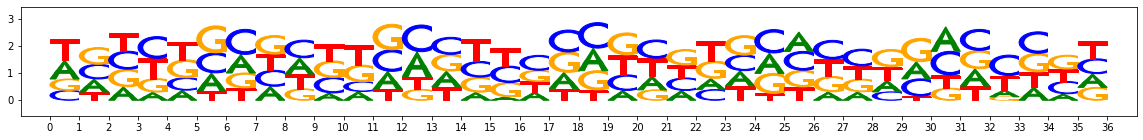

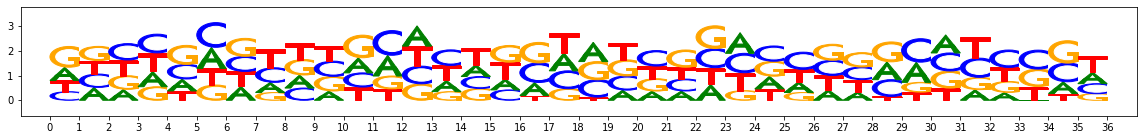

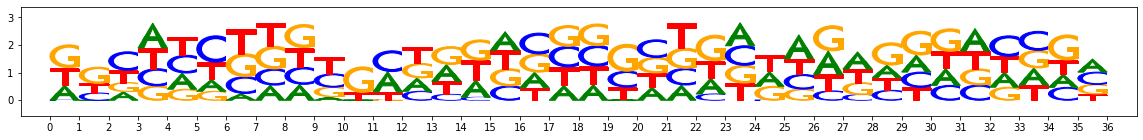

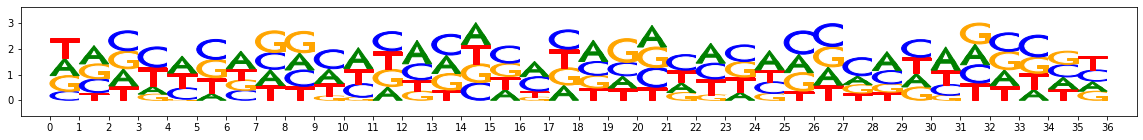

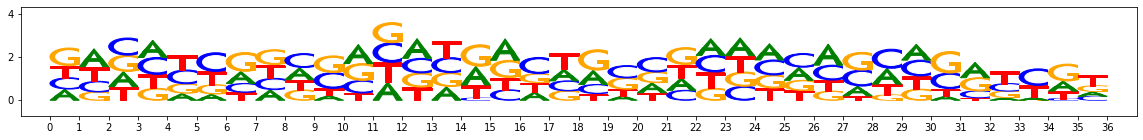

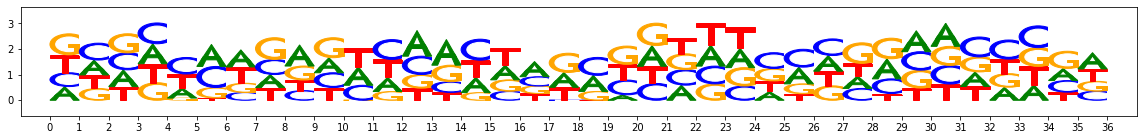

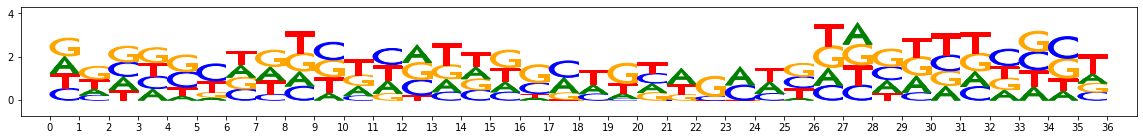

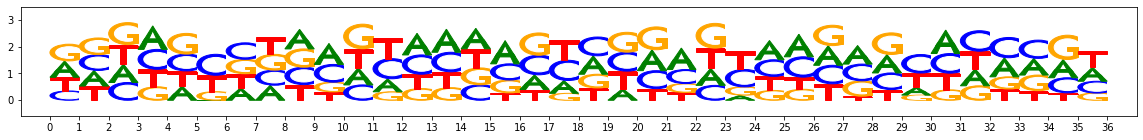

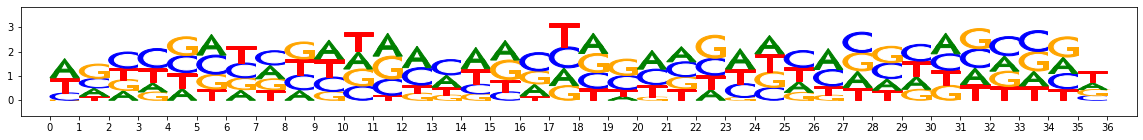

In [ ]:
# Visualize important sequence regions using tf-modisco

# This works when the data is separated into individual nucleotides
NUM_HI_SCORE_SEQ = 10
for i in range(NUM_HI_SCORE_SEQ):
  viz_sequence.plot_weights(shap_values_scaled[i], subticks_frequency=1)

In [ ]:
# Plot k-mers with summed gradient values

In [ ]:
nucs = np.unique(data.iloc[:,1:-3])

In [ ]:
# This is for combining nucleotides into k-mers (non-overlapping in the actual sequence)
K_MERS = 3
k_mers = np.zeros((shap_values_scaled.shape[0],K_MERS)).astype('str_')
for row in range(shap_values_scaled.shape[0]):
  k_mers[row] = np.array([nucs[np.argmax(shap_values_scaled[row,0])][0],nucs[np.argmax(shap_values_scaled[row,1])][0],\
                    nucs[np.argmax(shap_values_scaled[row,2])][0]])

In [ ]:
shap_reshaped = shap_values_scaled.reshape((shap_values_scaled.shape[0]*shap_values_scaled.shape[1],-1))

In [ ]:
# This is for combining nucleotides into k-mers (overlapping in the actual sequence) and attributing the summed
# gradient of each k-mer (here, three-mers) to the first nucleotide of the k-mer (as explained and graphed below).
K_MERS = 3
k_mers = np.zeros((shap_values_scaled[:,:36-1+K_MERS].shape[0],shap_values_scaled[:,:36-1+K_MERS].shape[1])).astype('str_')
k_mer_values = np.zeros((shap_values_scaled[:,:36-1+K_MERS].shape[0],shap_values_scaled[:,:36-1+K_MERS].shape[1]+1-K_MERS))
for row in range(shap_values_scaled[:,:36-1+K_MERS].shape[0]):
  for kmer in range(shap_values_scaled[:,:36-1+K_MERS].shape[1]+1-K_MERS):
    k_mers[row,kmer:kmer+K_MERS] = np.array([nucs[np.argmax(shap_values_scaled[row,kmer])][0],\
                                             nucs[np.argmax(shap_values_scaled[row,kmer+1])][0],\
                                             nucs[np.argmax(shap_values_scaled[row,kmer+2])][0]])
    k_mer_values[row,kmer] = np.sum(np.array([shap_values_scaled[row,np.argmax(shap_values_scaled[row,kmer])],\
                                              shap_values_scaled[row,np.argmax(shap_values_scaled[row,kmer+1])],\
                                              shap_values_scaled[row,np.argmax(shap_values_scaled[row,kmer+2])]]))
    #for k_mer_value in range(k_mer_values[row]+1-K_MERS):
    #  values_sum = np.sum(k_mer_values[row,k_mer_value:k_mer_value+3])

In [ ]:
# This is for combining nucleotides into k-mers (non-overlapping in the actual sequence) and attributing the summed
# gradient of each k-mer (here, three-mers) to the first nucleotide of the k-mer (as explained and graphed below).
k_mers = np.zeros((shap_values_scaled.shape[0],shap_values_scaled.shape[1])).astype('str_')
k_mer_values = np.zeros((shap_values_scaled.shape[0],shap_values_scaled.shape[1]))
for row in range(shap_values_scaled.shape[0]):
  for kmer in range(shap_values_scaled.shape[1]):
    k_mers[row,kmer] = nucs[np.argmax(shap_values_scaled[row,kmer])]
    k_mer_values[row,kmer] = shap_values_scaled[row,kmer,np.argmax(shap_values_scaled[row,kmer])]

In [ ]:
k_mer_values_df = pd.DataFrame(np.column_stack((k_mers[0,].T,k_mer_values[0].T)), columns=['Nucleotide', 'IG'])

In [ ]:
k_mer_values_df['Position'] = np.arange(k_mer_values_df.shape[0])

In [ ]:
# The figures in the plot below are summed per k-mer. That is, when looking at a k-mer with the first
# nucleotide at position x, the k-mer's summed gradient value is attributed to the nucleotide at position x.
# Thus, for example, the three-mer starting at position [1-35] is [XXX], with the summed gradient attributed to the first nucleotide

fig = px.bar(k_mer_values_df, x='Position', y='IG', color='Nucleotide')
 
fig.show()

In [ ]:
# This is for combining nucleotides into k-mers (overlapping in the actual sequence)
K_MERS = 3
k_mers = np.zeros((shap_reshaped.shape[0]+1-K_MERS,K_MERS)).astype('str_')
k_mer_values = np.zeros((shap_reshaped.shape[0]))
for row in range(shap_reshaped.shape[0]+1-K_MERS):
  k_mers[row,:K_MERS] = np.array([nucs[np.argmax(shap_reshaped[row])][0],nucs[np.argmax(shap_reshaped[row+1])][0],\
                    nucs[np.argmax(shap_reshaped[row+2])][0]])
  k_mer_values[row] = np.max(shap_reshaped[row])

In [ ]:
# This simply combines the nucleotides of each k-mer into one column
k_mers_df = pd.DataFrame(np.column_stack((k_mers,k_mer_values[:-2])),columns=['Nucs','y','z','IG'])
k_mers_df.iloc[:,0] = k_mers_df.iloc[:,0].str.cat(k_mers_df.iloc[:,1], sep='')
k_mers_df.iloc[:,0] = k_mers_df.iloc[:,0].str.cat(k_mers_df.iloc[:,2], sep='')
k_mers_df.drop(columns=['y','z'], inplace=True)
#k_mers_df['IG'] = np.expand_dims(k_mer_values,0)

In [ ]:
k_mers_df['IG'] = k_mers_df['IG'].astype('float64')

In [ ]:
k_mers_df.groupby('Nucs').IG.agg(['sum','mean','count']).sort_values(['mean'], ascending=False)

,sum,mean,count
Nucs,,,
ACC,48.009998,0.842281,57
GTA,35.235116,0.838931,42
GAC,37.250090,0.827780,45
ACG,24.591751,0.819725,30
ATC,17.190658,0.818603,21
...,...,...,...
TTC,15.209563,0.691344,22
TTA,9.663558,0.690254,14
TGC,36.193157,0.682890,53
